In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mColors
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from tqdm import tqdm_notebook as tqdm

root = './DIP_2019_A1/'

# pip install jupyter_contrib_nbextensions
# ! jupyter contrib nbextension install --user
# ! jupyter nbextension enable codefolding/main
#! jupyter nbextension disable toc2/main

In [2]:
def read_img(name, gray=False):
    fg = cv2.imread(name)
    fg = cv2.cvtColor(fg, cv2.COLOR_BGR2RGB)
    if gray: fg = cv2.cvtColor(fg, cv2.COLOR_RGB2GRAY)
    return fg


In [3]:
def plot(imgs, gray=False, titles=[], FigSize=(20,8), vmap=None):
    fig = plt.figure(figsize=FigSize)
    if len(imgs)>=3: num_plots = (np.ceil(len(imgs)/3.0),3)
    else: num_plots = (np.ceil(len(imgs)/3.0),len(imgs))
        
    vflag = True
    for i in range(len(imgs)):
        ax = fig.add_subplot(*num_plots, i+1)
        if not (vmap!=None and vflag):
            vflag=False
            vmap={}
            vmap['vmin']=np.min(imgs[i])
            vmap['vmax']=np.max(imgs[i])
        
        if not gray: ax.imshow(imgs[i])
        else: ax.imshow(imgs[i], cmap='gray', **vmap)
            
        ax.axis("off")            
        if i<len(titles): ax.title.set_text(titles[i])


In [4]:
def plot_og_scale(imgs, gray=False, titles=[], FigSize=(20,8)):
    fig = plt.figure(figsize=FigSize)
    if len(imgs)>=3: num_plots = (np.ceil(len(imgs)/3.0),3)
    else: num_plots = (np.ceil(len(imgs)/3.0),len(imgs))
        
    for i in range(len(imgs)):
        ax = fig.add_subplot(*num_plots, i+1)
        if not gray: ax.imshow(imgs[i])
        else: ax.imshow(imgs[i], cmap='gray', vmin=0, vmax=255)
        ax.axis("off")            
        if i<len(titles): ax.title.set_text(titles[i])


---
<div width="100%" align="center"> <h1>Q1</h1></div>

---

## 1. Most frequent color

In [159]:
fg = cv2.imread(root+'fg.jpg')
fg = cv2.cvtColor(fg, cv2.COLOR_BGR2RGB)
bg = cv2.imread(root+'bg.jpg')
bg = cv2.cvtColor(bg, cv2.COLOR_BGR2RGB)

fg.shape

(720, 1280, 3)

In [160]:
def get_most_freq_color(img):
    I = np.array(img, dtype=np.float64)
    
    counts = np.zeros((256,256,256))
    
    ma = -1
    mac = []
    for i in tqdm(range(I.shape[0])):
        for j in range(I.shape[1]):
            r = int(I[i,j,0])
            g = int(I[i,j,1])
            b = int(I[i,j,2])
            counts[r,g,b] += 1
            
            if counts[r,g,b]>ma:
                ma = counts[r,g,b]
                mac = np.array([[r],[g],[b]])
    return mac

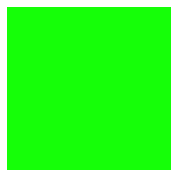

In [161]:
mac = get_most_freq_color(fg).reshape((3))
a = np.zeros((3,3,3))
for i in range(3):
    for j in range(3):
        a[i,j,:] = mac

plot([np.array(a, dtype=np.uint8)], FigSize=(3,3))

## 2. Merge Images
1. Find the most frequently occuring color in fg. This will be the background(assume).
2. Make a mask of 1 and 0. 1 in the pixels where we have the background. 0 others.  
        a. Background is determined by finding the **cosine similarity** between each pixel of the image (taken as a 
           [R,G,B] vector) and a [R,G,B] vector of the background color.
        b. If the angle between the vectors is more than 18 deg, we say that the pixel is fg, else bg.
3. Multiply the mask with the bg and inverse of the mask with fg and add to get the final img

In [162]:
def mergeImage(fg, bg, epsilon=0.8):
    fg = fg.copy()
    bg = bg.copy()
    
    mac = get_most_freq_color(fg)
    
    fg_corrected = np.array(fg,dtype=np.float64) + 0.00001
    x = np.sum(fg_corrected*mac.reshape(1,1,3), axis=2)
    x = x / np.sqrt(np.sum(fg_corrected*fg_corrected, axis=2))
    x = x / np.sqrt(np.sum(mac.reshape(1,1,3)*mac.reshape(1,1,3), axis=2))
    
    t = (x > epsilon) # t is the matrix telling us which squares to remove from fg(if true, then remove)
    t = t.reshape((t.shape[0], t.shape[1], 1))
    
    fg = np.array(~t, dtype=np.uint8)*fg + np.array(t, dtype=np.uint8)*bg
    t = t.reshape((720,1280))
    
    a = np.zeros((3,3,3))
    for i in range(3):
        for j in range(3):
            a[i,j,:] = mac.reshape(3)
    a = np.array(a, dtype=np.uint8)
    plot([t, a], gray=True, FigSize=(8,8), titles=["FG MASK", "BG COLOR"])
    return fg

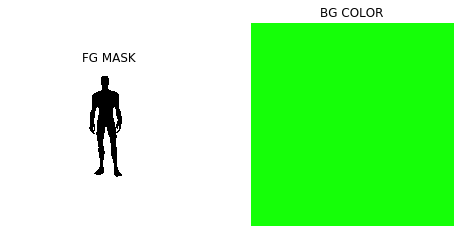

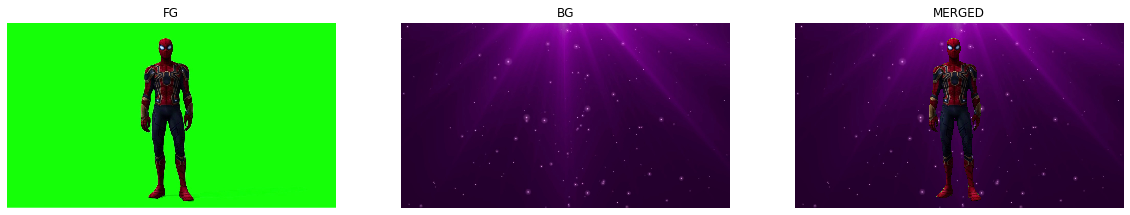

In [164]:
op = mergeImage(fg,bg,epsilon=0.90)

plot([fg,bg,op], FigSize=(20,20), titles=["FG", "BG", "MERGED"])

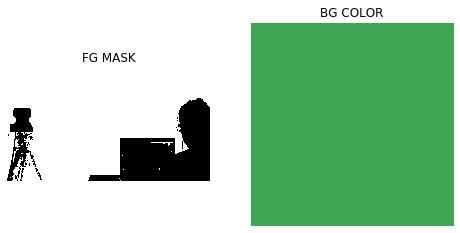

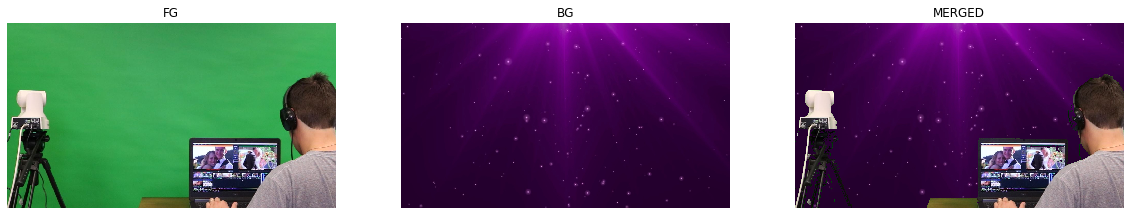

In [351]:
fg1 = read_img('./input/fg_complex.jpg')
fg1 = fg1[100:820,100:1380,:]
op = mergeImage(fg1,bg,epsilon=0.95)
plot([fg1,bg,op], FigSize=(20,20),  titles=["FG", "BG", "MERGED"])

---
<div width="100%" align="center"> <h1>Q2</h1></div>

---

## 1. Line Contrast Stretching

In [123]:
fg = read_img(root+'cameraman.png', gray=True)

In [124]:
def getColorbar(img, k):
    h = []
    for i in range(256):
        h.append(np.sum(np.array(img == i, dtype=np.float64)))
    idxs = np.argsort(np.array(h))[::-1]
#     print(idxs)
    idxs = idxs[:k, np.newaxis]
    
    [for i in range(img.shape[1])]
    return 

In [131]:
def linContrastStretching(img, a, b):
    '''
    min maps to a
    max maps to b
    basically a line between (min,a) and (max,b)
    s = (b-a)/(max-min) (r-min) + a
    '''
    
    img = np.array(img, dtype=np.float64)
    m = np.min(img)
    M = np.max(img)
    
    img_dash = np.round((b-a)*(img-m)/(M-m) + a, decimals=0)
    
    a = getColorbar(img,20)
    print(a)
    
    fig = plt.figure(figsize = (30, 10))
    grid = gridspec.GridSpec(1,10)
    
    ax = fig.add_subplot(grid[0, 0:4])
    ax.imshow(img, cmap = 'gray', vmin=0, vmax =255)
    
    ax2 = fig.add_subplot(grid[0,4])
    ax2.imshow(a, cmap='gray', vmin=0, vmax=255)
    ax2.axis("off")
    
    ax3 = fig.add_subplot(grid[0,5:9])
    ax4 = fig.add_subplot(grid[0,9])
    
    return img_dash

[[ 14]
 [ 13]
 [  9]
 [ 12]
 [ 15]
 [ 10]
 [162]
 [164]
 [165]
 [ 11]
 [163]
 [166]
 [168]
 [ 16]
 [167]
 [169]
 [161]
 [160]
 [170]
 [159]]


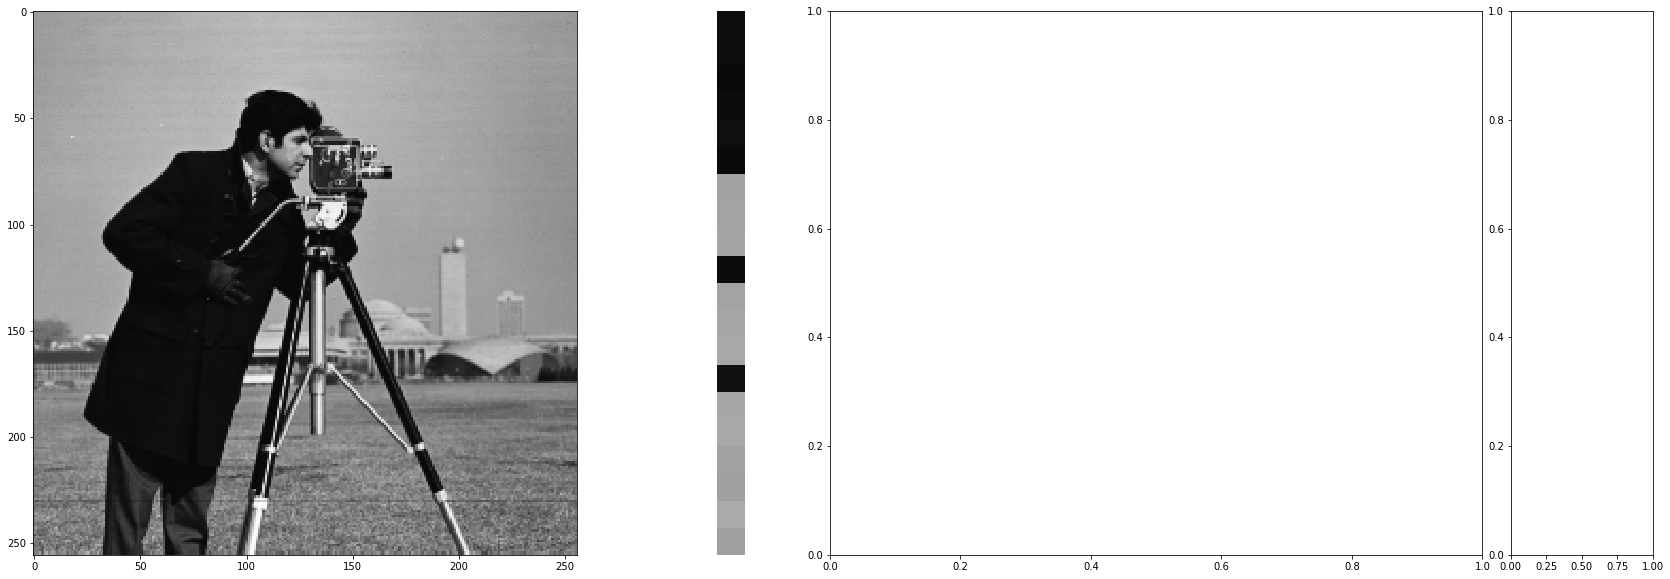

In [132]:
a = linContrastStretching(fg, 100,200)
# a = linContrastStretching(a, 0,255)

---
<div width="100%" align="center"> <h1>Q3</h1></div>

---

## 1.

In [135]:
img = read_img(root+'quantize.jpg')

In [149]:
def BitQuantizeImage(im, k, Plot=True):
    im = np.array(im, dtype=np.float64)
    im_dash = np.floor(im/np.power(2,8-k))*np.power(2,8-k)
    im_dash = np.array(im_dash, dtype=np.uint8)
    im = np.uint8(im)
    
    if Plot:
        plot([im, im_dash], FigSize=(10,10), titles=["original", "{} bit quantised".format(k)])

    return im_dash
    

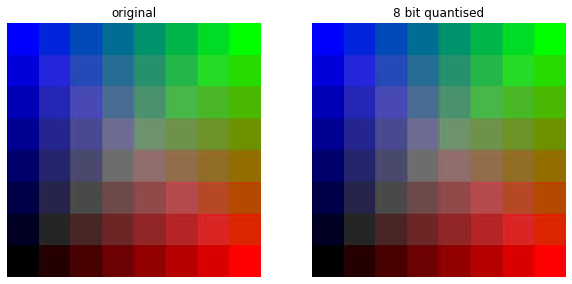

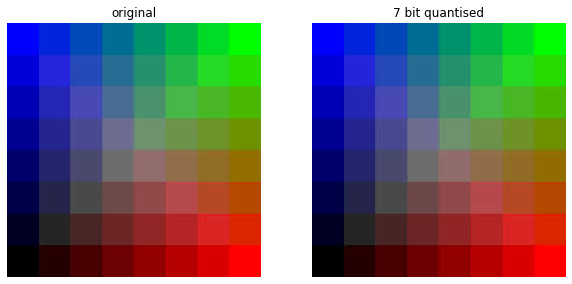

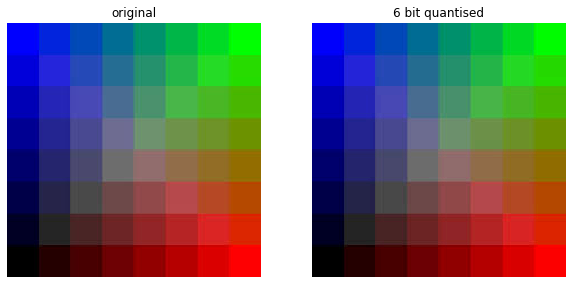

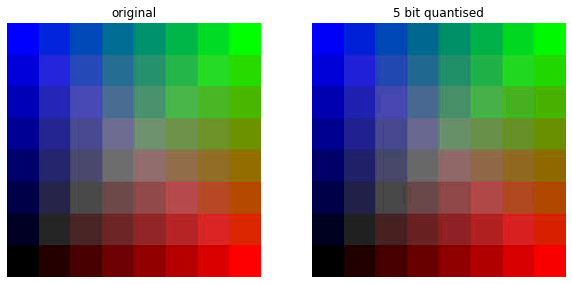

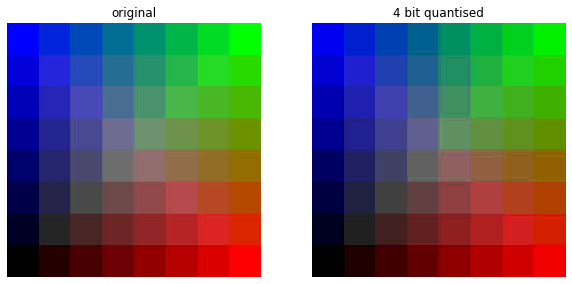

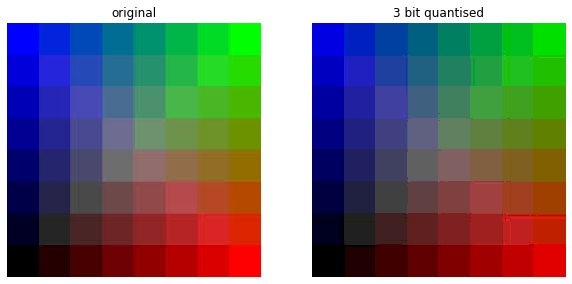

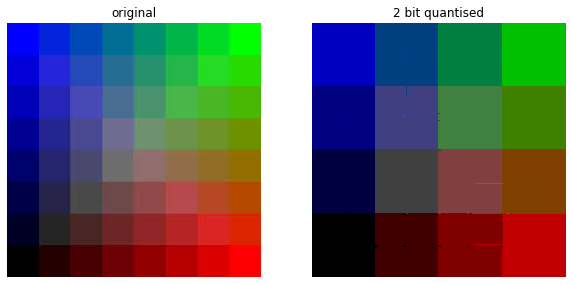

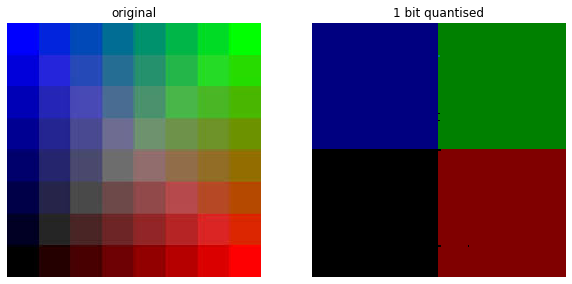

In [150]:
a = BitQuantizeImage(img, 8)
a = BitQuantizeImage(img, 7)
a = BitQuantizeImage(img, 6)
a = BitQuantizeImage(img, 5)
a = BitQuantizeImage(img, 4)
a = BitQuantizeImage(img, 3)
a = BitQuantizeImage(img, 2)
a = BitQuantizeImage(img, 1)



## 2. Bit Plane Extraction

In [17]:
img = read_img(root+'cameraman.png')
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [18]:
def bitPlaneExtraction(img, Plot=True):
    imgs = [img.copy()]
    
    p = 1
    for i in range(8):
        p = np.power(2,i)
        timg = img & p
        timg = np.array(timg>0, dtype=np.uint8)
        imgs.append(timg.copy())
    
    if Plot: plot(imgs, gray=True, FigSize=(10,10), titles=["Original", *("{} bitplane".format(i+1) for i in range(8))])
    return imgs

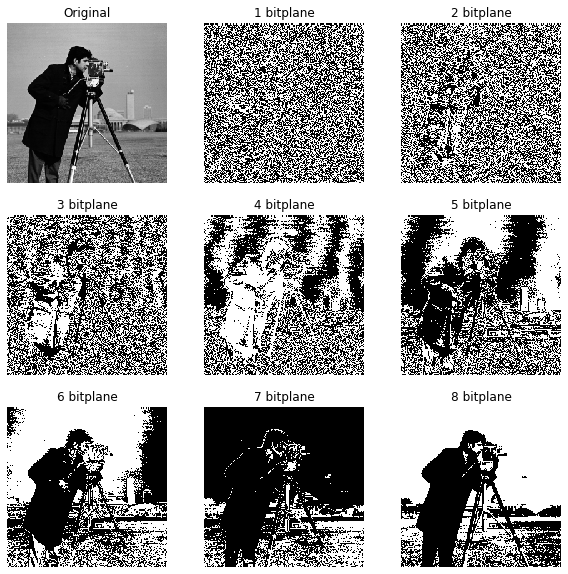

In [19]:
a = bitPlaneExtraction(img)

## 3. Lena Image Operations

In [246]:
img = read_img(root+'lena.jpg', gray=True)
img1 = read_img(root+'lena1.jpg', gray=True)
img2 = read_img(root+'lena2.jpg', gray=True)
img3 = read_img(root+'lena3.jpg', gray=True)

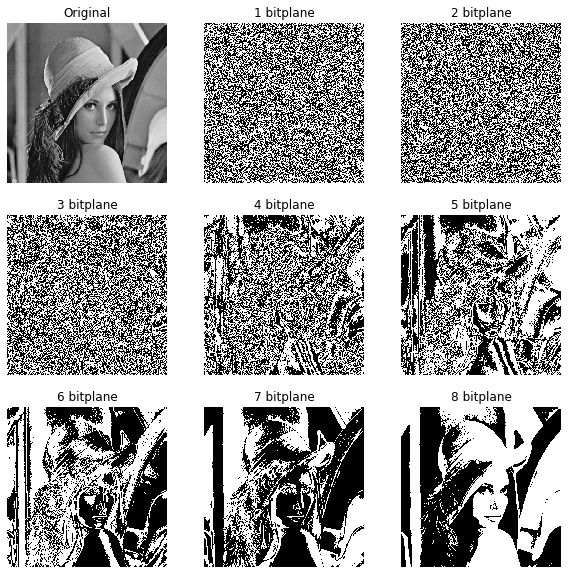

In [247]:
a = bitPlaneExtraction(img)

### a) LENA1
The operation is ***extracting the 5th bit plane***

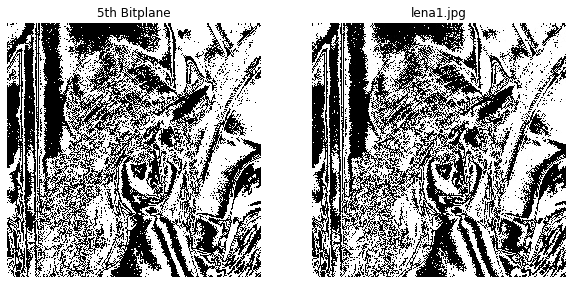

In [251]:
a = bitPlaneExtraction(img, Plot=False)
timg = a[5]
plot([timg, img1], gray=True, titles=["5th Bitplane", "lena1.jpg"], FigSize=(10,10))

### b) LENA2
The operation is ***quantisation to 2 bits***

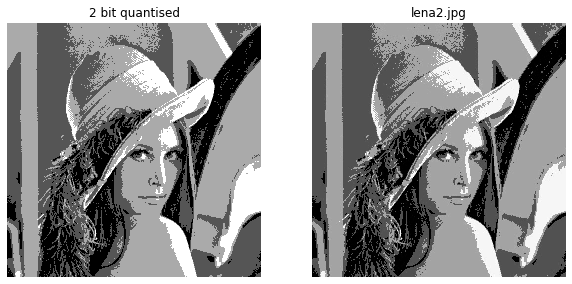

In [252]:
timg = BitQuantizeImage(img, 2, plot=False)
plot([timg, img2], gray=True, titles=["2 bit quantised", "lena2.jpg"], FigSize=(10,10))

### c) LENA3
The operation is ***extracting the 8th bitplane***.

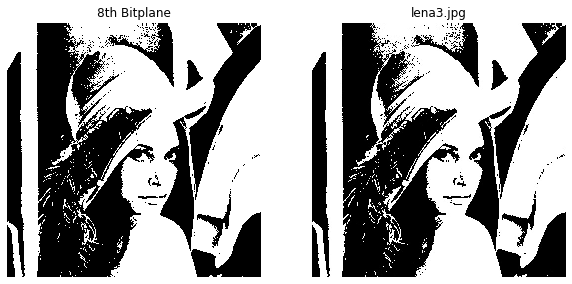

In [254]:
a = bitPlaneExtraction(img, Plot=False)
timg = a[8]
plot([timg, img3], gray=True, titles=["8th Bitplane", "lena3.jpg"], FigSize=(10,10))

---
<div width="100%" align="center"> <h1>Q4</h1></div>

---

## 1. Negative of an Image

In [256]:
img = read_img(root+"lena.jpg", gray=True)

In [269]:
def negativeImage(img, max_intensity, Plot=True):
    '''
    0 maps to L-1
    L-1 maps to 0
    L is the number of gray levels(max_intensity)
    '''
    
    img_dash = max_intensity-img.copy()
    if Plot: plot([img, img_dash], gray=True, FigSize=(10,10))
    return img_dash

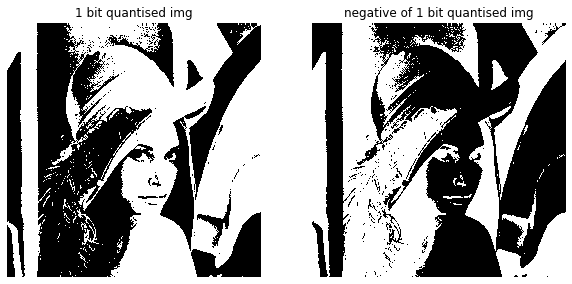

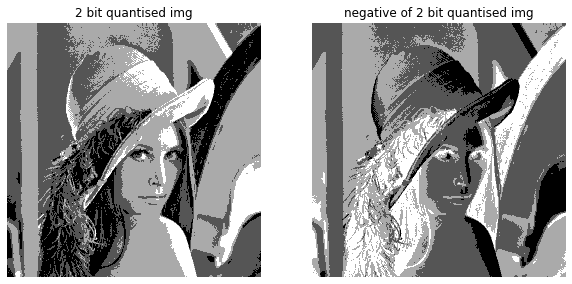

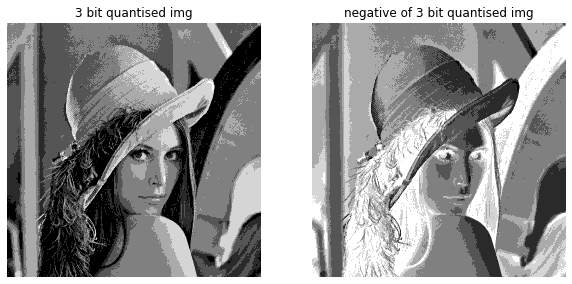

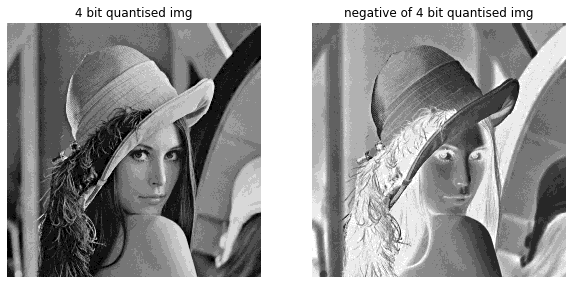

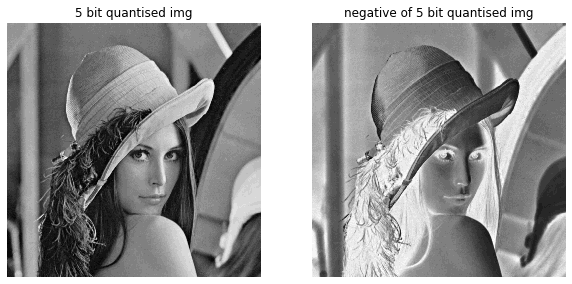

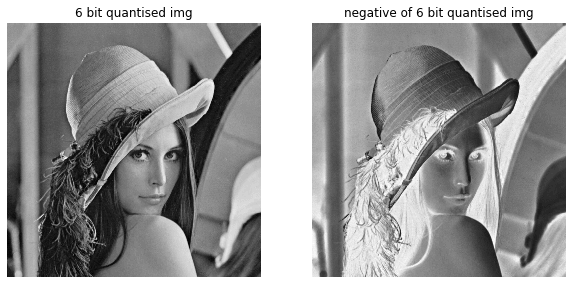

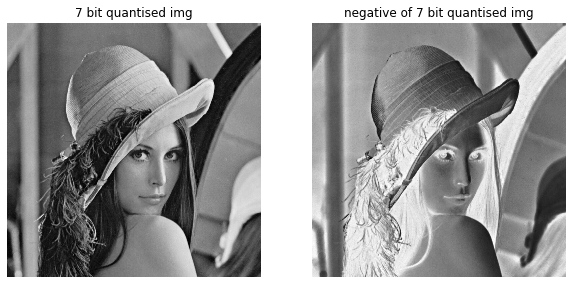

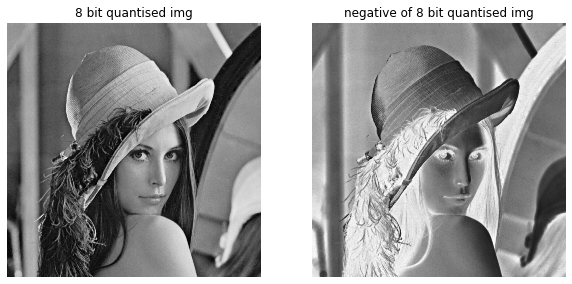

In [272]:
for i in range(1,9):
    timg = BitQuantizeImage(img, i, plot=False)
    neg_timg = negativeImage(timg, max_intensity=np.max(timg), Plot=False)
    
    labels = ["{} bit quantised img".format(i), "negative of {} bit quantised img".format(i)]
    plot([timg, neg_timg], gray=True, titles=labels, FigSize=(10,10))

## 2. Gamma Transform

1. This is an ***Interactive Slider for Gamma (y)***
2. **Observations**  
        a. A higher value of gamma(greater than 1) causes:-
            * The lighter gray levels quickly saturate. Hence many near white grey levels become exactly white.
            * The lower grey levels also go to a more lighter shade. 
            
        b. A lower value of gamma(lower than 1) causes:-
            * All the shades become darker.
            * The darker shades are mapped to fewer values than lighter shades. ie, there is more loss of
              details in the darker grey values.

In [329]:
img = read_img(root+'gamma-corr.png', gray=True)

In [374]:
@interact(img=fixed(img), y=(0.1,2, 0.1), Plot=fixed(True))
def gammaTransform(img, y, Plot=True):
    img = np.array(img, dtype=np.float64)
    timg = np.array(np.clip(np.power(img, y), 0, 255), dtype=np.uint8)
    if Plot: plot([img, timg], gray=True, titles=["original", "modified"], FigSize=(15,15))

interactive(children=(FloatSlider(value=1.0, description='y', max=2.0, min=0.1), Output()), _dom_classes=('wid…

## 3. Peicewise Linear Transform

In [375]:
img = read_img(root+"lena.jpg", gray=True)

In [418]:
def peicewiseTransform(img, coeffs, intervals, Plot=True):
    img = np.array(img, dtype=np.float64)
    timg = np.zeros((img.shape[0], img.shape[1]))
    for i in range(len(intervals)):
        a,b = intervals[i]
        k1, k2 = coeffs[i]
        
        mask = np.array(b>=img, dtype=np.float64)
        mask = mask*np.array(a<=img, dtype=np.float64)
        
        timg = timg+mask*(k1*img+k2)
        
    timg = np.array(timg, dtype=np.uint8)
    if Plot==True: 
        plot([img, timg], gray=True, 
            vmap={'vmin': 0, 'vmax': 255}, FigSize=(20,20), 
            titles=["Original", "Linear Transform"])
        
    return timg    

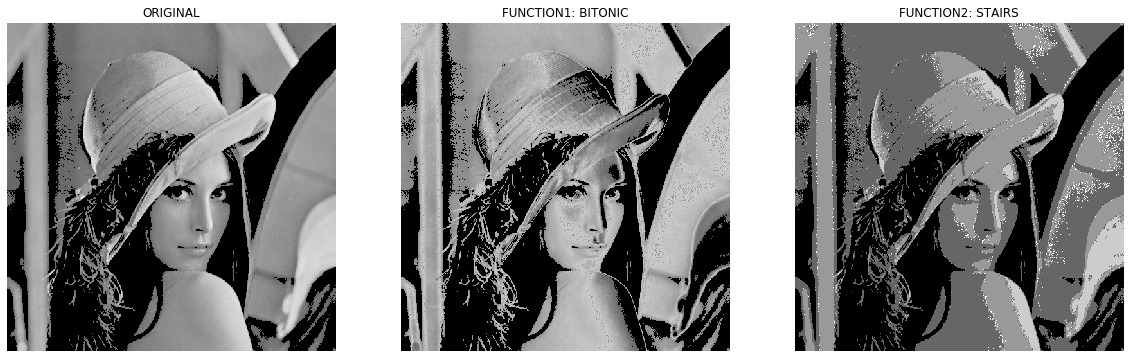

In [426]:
intervals = [(0,76), (77,153), (153, 204), (205, 255)]
coeff = [(0,0), (1.333,0), (-2, 510), (0, 0)]
a = peicewiseTransform(img, coeff, intervals, Plot=False)

intervals = [(i*25.5, (i+2)*25.5) for i in range(0,10,2)]
coeff = [(0,i*25.5) for i in range(0,10,2)]
b = peicewiseTransform(img, coeff, intervals, Plot=False)

plot([img, a,b], gray=True,
    vmap={'vmin': 0, 'vmax':255}, titles=['ORIGINAL', 'FUNCTION1: BITONIC', 'FUNCTION2: STAIRS'])

---
<div width="100%" align="center"> <h1>Q5</h1></div>

---

## 3. Transmission Rate

In [427]:
from IPython.display import Markdown as md

number_of_bytes = 512*512
number_of_bauds = number_of_bytes
number_of_bits = 10*number_of_bauds

time_over_56K_link = number_of_bits/56000

time_over_3000K_link = number_of_bits/3000000

op = """### Answers\n\n 
\n\n
```
    number_of_bytes = 512*512
    number_of_bauds = number_of_bytes
    number_of_bits = 10*number_of_bauds

    time_over_56K_link = number_of_bits/56000
    time_over_3000K_link = number_of_bits/3000000
```
**Time to send over 56K link:** {}s  \n\
**Time to send over 3000K link:** {}s  \n\n\
*Assumption: 1K baud link= 1000 bits/sec*
""".format(time_over_56K_link, time_over_3000K_link)
md(op)

### Answers

 



```
    number_of_bytes = 512*512
    number_of_bauds = number_of_bytes
    number_of_bits = 10*number_of_bauds

    time_over_56K_link = number_of_bits/56000
    time_over_3000K_link = number_of_bits/3000000
```
**Time to send over 56K link:** 46.81142857142857s  
**Time to send over 3000K link:** 0.8738133333333333s  

*Assumption: 1K baud link= 1000 bits/sec*


---
<div width="100%" align="center"> <h1>Q6</h1></div>

---

## 1. Histogram equalisation

In [14]:
img1 = read_img(root+'part1.png', gray=True)
img2 = read_img(root+'part2.png', gray=True)
img3 = read_img(root+'part3.png', gray=True)
img4 = read_img(root+'part4.png', gray=True)

img = read_img(root+'canyon.png', gray=True)

eye = read_img(root+'eye.png', gray=True)
eyeref = read_img(root+'eyeref.png', gray=True)

In [6]:
def histEqualization(im, Plot=True, Tr=None):
    img = np.array(im, dtype=np.float64)
    n,m = img.shape[:2]
    
    if not Tr:
        Tr = [0 for i in range(256)]
    
    s = 0
    timg = np.zeros((n,m))
    
    for i in range(256):
        mask = np.array((img==i), dtype=np.float64)
        s += np.sum(mask)/(m*n)
        Tr[i] = np.floor(255 * s)
        timg = timg + mask*Tr[i]
    
    if Plot: 
        plot([img, timg], gray=True, FigSize=(15, 10), 
            vmap={'vmin': 0, 'vmax':255}, 
            titles=['ORIGINAL', 'HISTOGRAM EQUALISED'])
    
    return timg

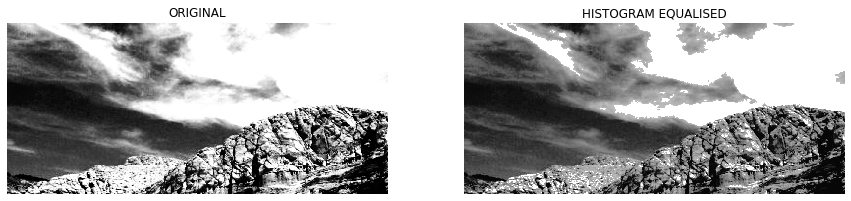

In [7]:
a = histEqualization(img1)

## 3. Histogram Matching

In [55]:
def histMatching(img, imgref, Plot=True):
    equalised_img = histEqualization(img, Plot=False)
    
    Tz = [0 for i in range(256)]
    e2 = histEqualization(imgref, Tr=Tz, Plot=False)
    Tz = np.array(Tz)
    
    timg = np.zeros(img.shape)
    
    for i in range(256):
        mask = np.array((equalised_img==i), dtype=np.float64)
        idx = np.argmax(Tz>=i)
        
        z = idx
        if not (Tz>=i).any():
            z = 255
        elif idx>0 and abs(Tz[idx-1]-i) < abs(Tz[idx]-i):
            z = idx-1
        
        if z>255: print(i,z)
        timg += mask*z
    
    if Plot==True:
        plot([img, imgref, timg], gray=True, vmap={'vmin':0, 'vmax':255})

        h1 = np.array([np.sum(np.array((img==i), dtype=np.float64)) for i in range(256)])
        h2 = np.array([np.sum(np.array((imgref==i), dtype=np.float64)) for i in range(256)])
        h3 = np.array([np.sum(np.array((timg==i), dtype=np.float64)) for i in range(256)])


        fig = plt.figure(figsize=(20,5))

        ax = fig.add_subplot(131)
        ax.stem(np.linspace(0,255,256), np.log2(1+h1), use_line_collection=True)
        ax.set_ylabel("Log2 (Counts)")

        ax2 = fig.add_subplot(132)
        ax2.stem(np.linspace(0,255,256), np.log2(1+h2), use_line_collection=True) 
        ax2.set_ylabel("Log2 (Counts)")

        ax3 = fig.add_subplot(133)
        ax3.stem(np.linspace(0,255,256), np.log2(1+h3), use_line_collection=True) 
        ax3.set_ylabel("Log2 (Counts)")
        
    return timg

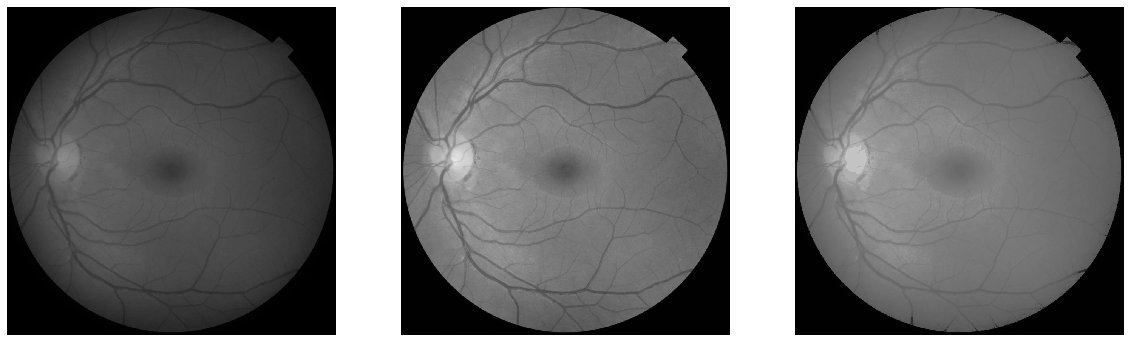

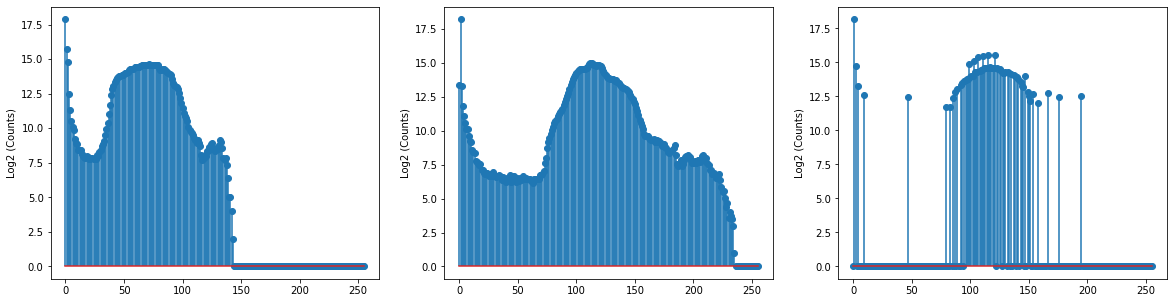

In [56]:
a = histMatching(eye, eyeref)

## 4. Recover Imgs

In [22]:
fimg = np.zeros((img.shape))
fimg[:img1.shape[0], :img1.shape[1]] = img1
fimg[:img1.shape[0], img1.shape[1]:] = img2
fimg[img1.shape[0]:, :img1.shape[1]] = img3
fimg[img1.shape[0]:, img1.shape[1]:] = img4

oimg = np.zeros((img.shape))

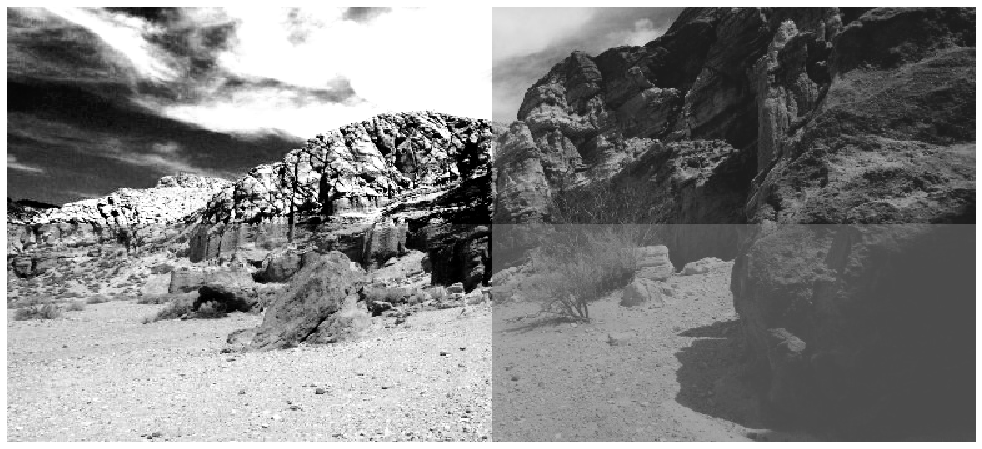

In [11]:
plot([fimg], gray=True)

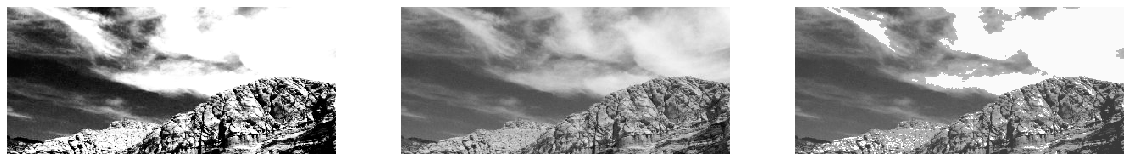

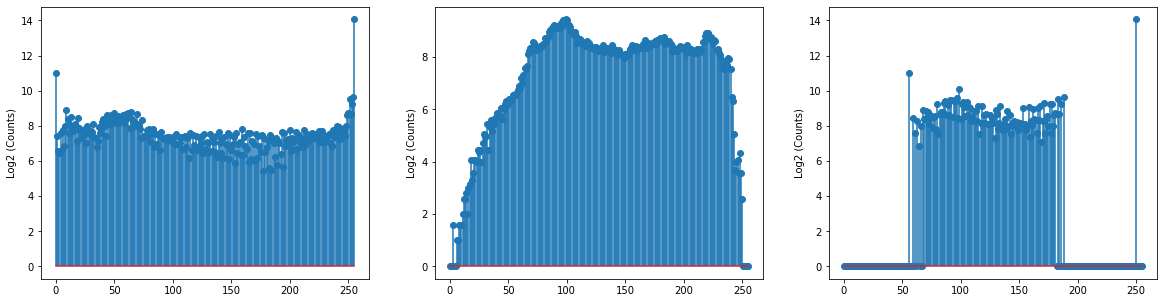

In [62]:
oimg[:img1.shape[0], :img1.shape[1]] = histMatching(img1, img[:img1.shape[0], :img1.shape[1]])

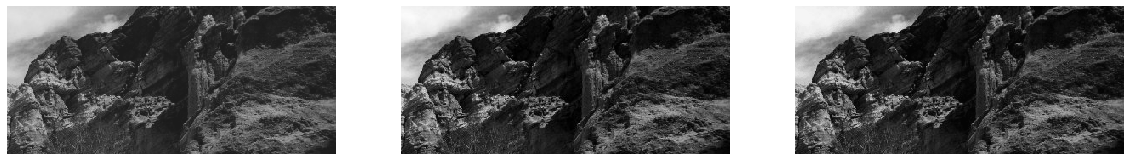

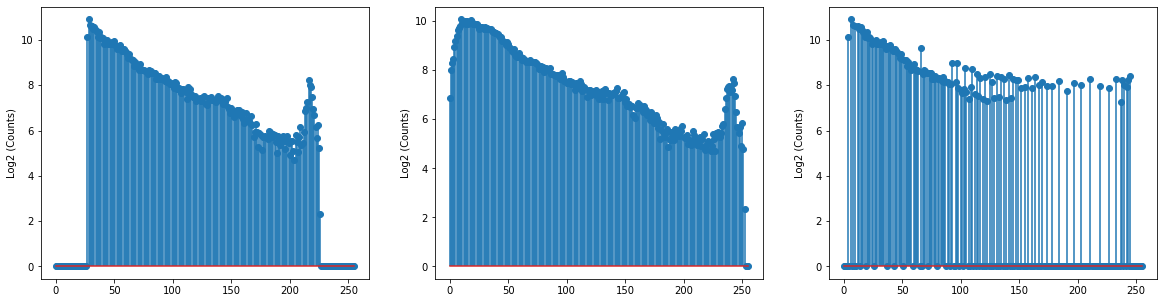

In [35]:
oimg[:img1.shape[0], img1.shape[1]:] = histMatching(img2, img[:img1.shape[0], img1.shape[1]:])

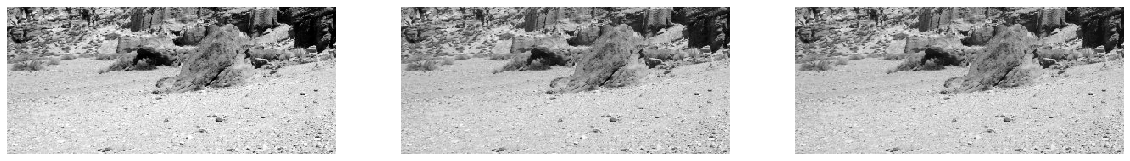

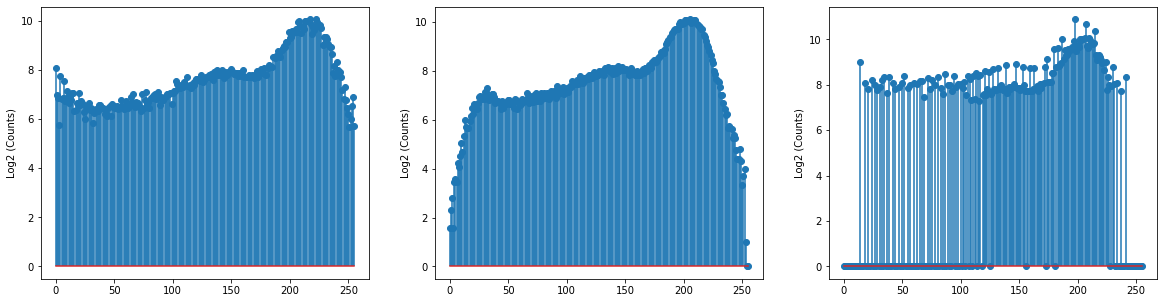

In [36]:
oimg[img1.shape[0]:, :img1.shape[1]]=histMatching(img3, img[img1.shape[0]:, :img1.shape[1]])

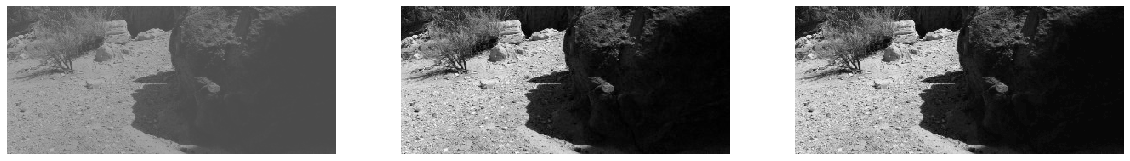

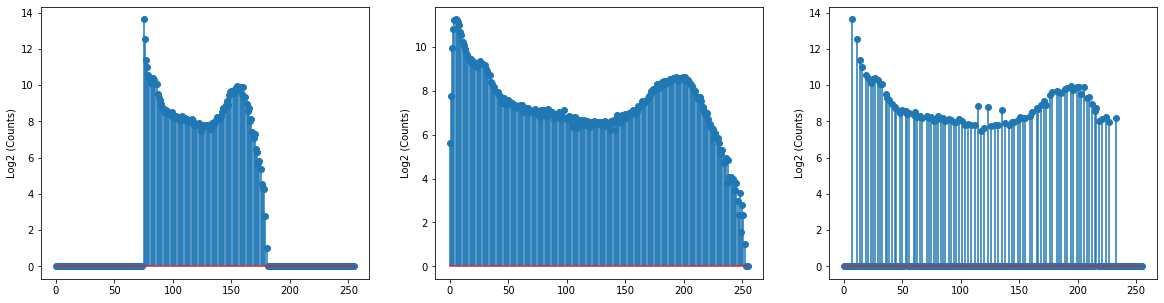

In [37]:
oimg[img1.shape[0]:, img1.shape[1]:] = histMatching(img4, img[img1.shape[0]:, img1.shape[1]:])

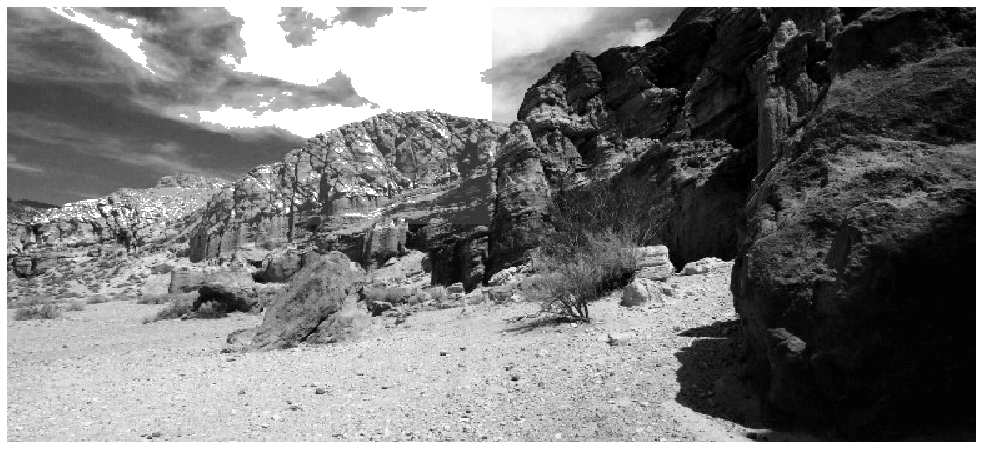

In [64]:
plot([oimg], gray=True)

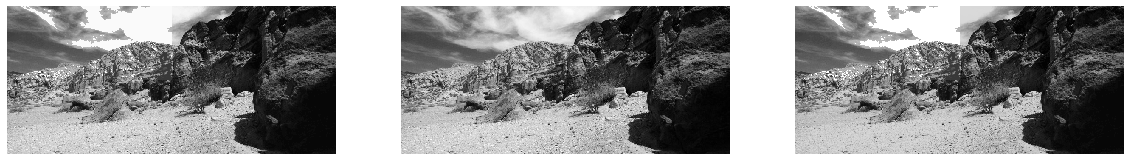

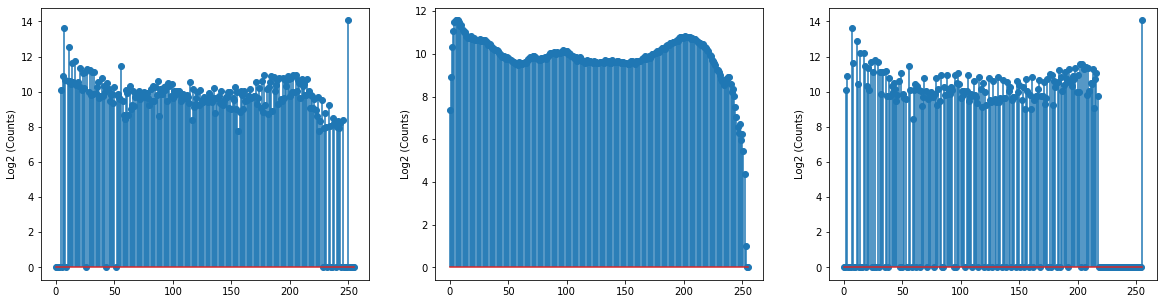

In [57]:
a = histMatching(oimg, img, Plot=True)
# plt.imshow(a, cmap='gray', vmin=0, vmax=255)


array([[42., 42., 42., ..., 42., 42., 42.],
       [42., 42., 42., ..., 42., 42., 42.],
       [42., 42., 42., ..., 42., 42., 42.],
       ...,
       [42., 42., 42., ..., 42., 42., 42.],
       [42., 42., 42., ..., 42., 42., 42.],
       [42., 42., 42., ..., 42., 42., 42.]])

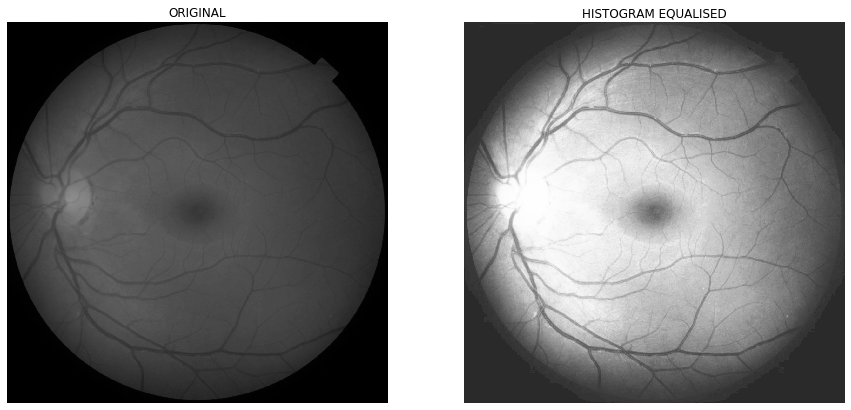

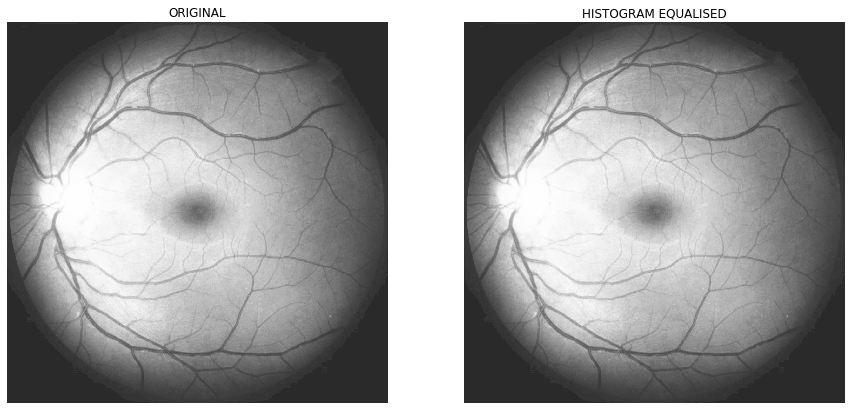

In [66]:
histEqualization(histEqualization(eye))